
> **ISO2024 INTRODUCTORY SPATIAL 'OMICS ANALYSIS**
>
>
>- HYBRID : TORONTO & ZOOM
>- 9TH JULY 2024 <br>

>**Module 6 : Realizing the spatial potential in your datasets, part 2 ** <BR>
>
>**Instructor : Shamini Ayyadhury**
>
---

> TOPICS COVERED

* A. Centrality scores *
* B. Ripley's L statistics *

***

In [1]:
### Import packages

### we will be using the builtu-in functions of squidpy to perform the analysis

import squidpy as sq
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [16]:
data_dir = '/home/shamini/data1/data_orig/data/spatial/xenium/10xGenomics/mice_AD_model/wt/module6/' ### data directory
out = '/home/shamini/data/projects/spatial_workshop/out/module3/objects/' ### data directory

names = ['wt', 'AD']

In [17]:
adatas = []

adata = sc.read_h5ad(data_dir + 'adata_wt_banksy.h5ad')
adata = adata[adata.obs['cell_label'].notna()]
adatas.append(adata)

adata = sc.read_h5ad(out + 'adata_module3b_banksy.h5ad')
adata = adata[adata.obs['cell_label'].notna()]
adatas.append(adata)

for adata in adatas:
    print(adata)
    print('')


View of AnnData object with n_obs × n_vars = 59145 × 347
    obs: 'gene_counts', 'neg_counts', 'x_location', 'y_location', 'n_genes', 'n_counts', 'cell_label', 'labels_nonspatial_pc18_nc0.00_r0.30', 'labels_scaled_gaussian_pc18_nc0.25_r0.30', 'labels_scaled_gaussian_pc18_nc0.50_r0.30', 'labels_scaled_gaussian_pc18_nc0.75_r0.30', 'labels_scaled_gaussian_pc18_nc1.00_r0.30'
    var: 'n_cells'
    uns: 'cell_label_colors', 'labels_nonspatial_pc18_nc0.00_r0.30_colors', 'labels_scaled_gaussian_pc18_nc0.25_r0.30_colors', 'labels_scaled_gaussian_pc18_nc0.75_r0.30_colors', 'labels_scaled_gaussian_pc18_nc1.00_r0.30_colors', 'n_genes_mean', 'n_genes_med', 'pearson_residuals_normalization', 'spatial'
    obsm: 'pc18_banksy', 'spatial', 'umap18_banksy'

View of AnnData object with n_obs × n_vars = 60099 × 347
    obs: 'gene_counts', 'neg_counts', 'x_location', 'y_location', 'n_genes', 'n_counts', 'cell_label', 'leiden_pca', 'leiden_spatial', 'labels_nonspatial_pc18_nc0.00_r0.30', 'labels_scaled_gau

In [18]:


### Step 1: Calculate spatial neighbors
### PARTICIPANTS TO PLAY AROUND WITH THE PARAMETERS

for adata in adatas:
    sq.gr.spatial_neighbors(adata, coord_type="generic", n_rings=2, delaunay=True)


/home/shamini/anaconda3/envs/xenium/lib/python3.10/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data
/home/shamini/anaconda3/envs/xenium/lib/python3.10/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


In [19]:
from copy import deepcopy

deep_centrals = []
ser_closeness = []
ser_degree = []
ser_cluster = []

for i, adata in enumerate(adatas):
    ### calling squidpy function to calculate the centrality scores
    sq.gr.centrality_scores(adata, "cell_label")

    # copy centrality data to new DataFrame
    deep_central = deepcopy(adata.uns["cell_label_centrality_scores"])

    # sort clusters based on centrality scores
    # closeness centrality - measure of how close the group is to other nodes.
    ser_closeness.append(deep_central["closeness_centrality"].sort_values(ascending=False))

    ser_degree.append(deep_central["degree_centrality"].sort_values(ascending=False))

    # clustering coefficient - measure of the degree to which nodes cluster together.
    ser_cluster.append(deep_central["average_clustering"].sort_values(ascending=False))
    
    deep_centrals.append(deep_central)

['Astro', 'Oligo', 'Macrophage', 'Endo', 'L6 IT']
['NP', 'CR', 'L5 PT', 'Serpinf1', 'Peri']
['Astro', 'Oligo', 'Macrophage', 'Endo', 'Sncg']
['L5 IT', 'SMC', 'NP', 'L5 PT', 'Serpinf1']


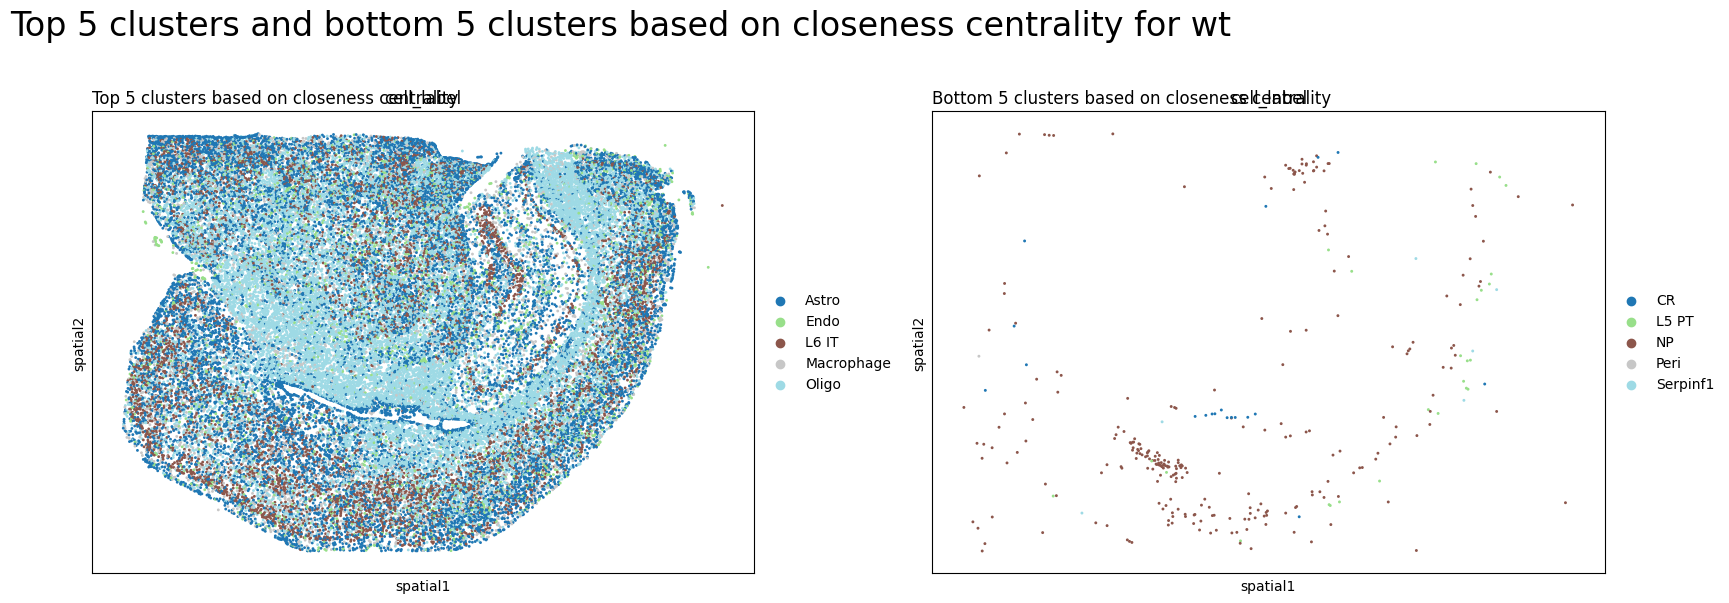

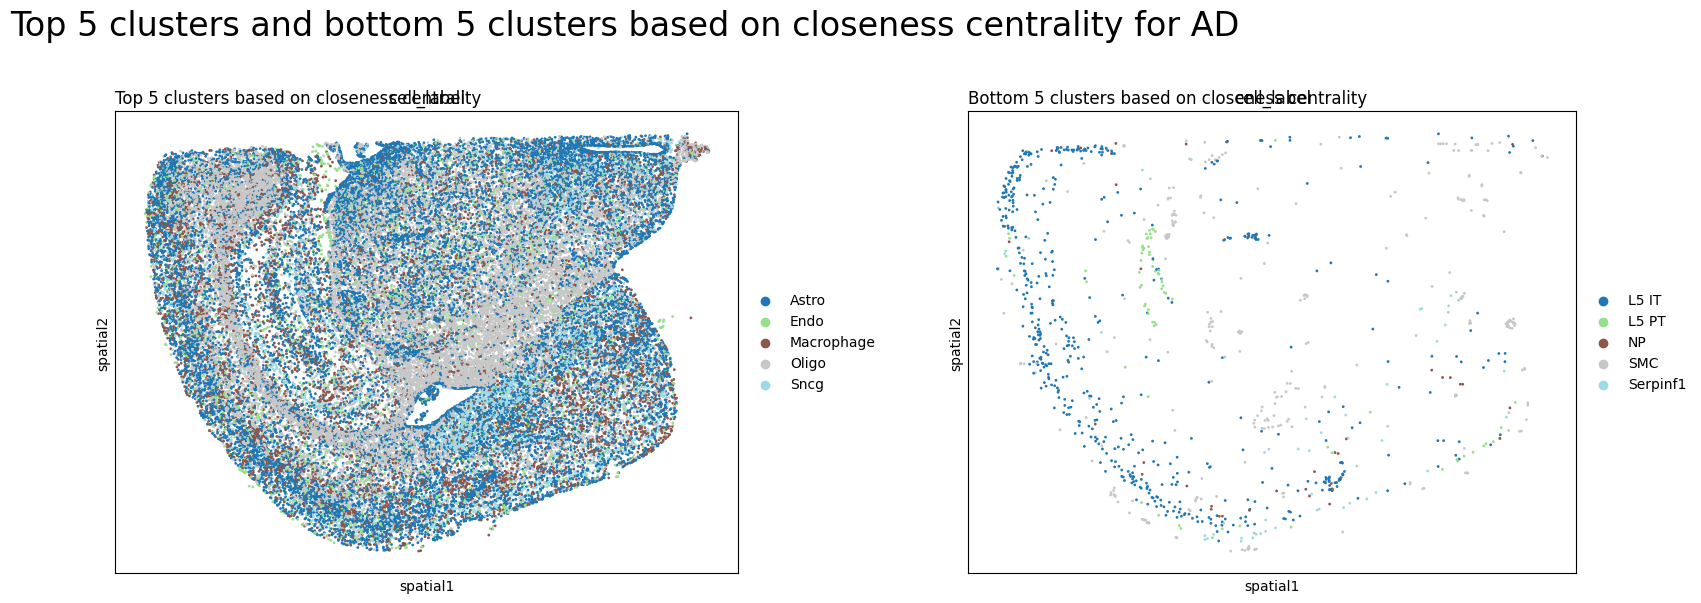

In [21]:

for i, closeness in enumerate(ser_closeness):
    inst_clusters = closeness.index.tolist()[:5]
    print(inst_clusters)

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f"Top 5 clusters and bottom 5 clusters based on closeness centrality for {names[i]}", fontsize=24, y=1.05, x=0.4)

    sq.pl.spatial_scatter(
        adatas[i], groups=inst_clusters, color="cell_label", size=15, img=False, figsize=(10, 10), palette="tab20", ax=axs[0]
    )
    axs[0].set_title("Top 5 clusters based on closeness centrality", loc="left")

    inst_clusters = closeness.index.tolist()[-5:]
    print(inst_clusters)
    sq.pl.spatial_scatter(
        adatas[i], groups=inst_clusters, color="cell_label", size=15, img=False, figsize=(10, 10), palette="tab20", ax=axs[1]
    )
    axs[1].set_title("Bottom 5 clusters based on closeness centrality", loc="left")

In [22]:
for adata in adatas:
    sq.gr.ripley(adata, 
                  cluster_key='cell_label', 
                  mode='L', 
                  spatial_key='spatial', 
                  metric='euclidean', 
                  n_neigh=2, 
                  n_simulations=50, n_observations=1000, 
                  max_dist=None, 
                  n_steps=50, 
                  seed=None, 
                  copy=False)


In [24]:
df_cell_ripley = []
sim = []

for adata in adatas:
    df_cell_ripley.append(pd.DataFrame(adata.uns['cell_label_ripley_L']['L_stat']))
    s = (pd.DataFrame(adata.uns['cell_label_ripley_L']['sims_stat']))
    s.columns = ['bins', 'cell_label', 'stats']
    s['cell_label'] = 'sim'
    sim.append(s)


In [26]:
df_cell_ripley_high_cen = []
df_cell_ripley_low_cen = []

for i, closeness in enumerate(ser_closeness):
    df_cell_ripley_high_cen.append(df_cell_ripley[i][df_cell_ripley[i]['cell_label'].isin(closeness.index.tolist()[:5])].copy())
    df_cell_ripley_low_cen.append(df_cell_ripley[i][df_cell_ripley[i]['cell_label'].isin(closeness.index.tolist()[-5:])].copy())

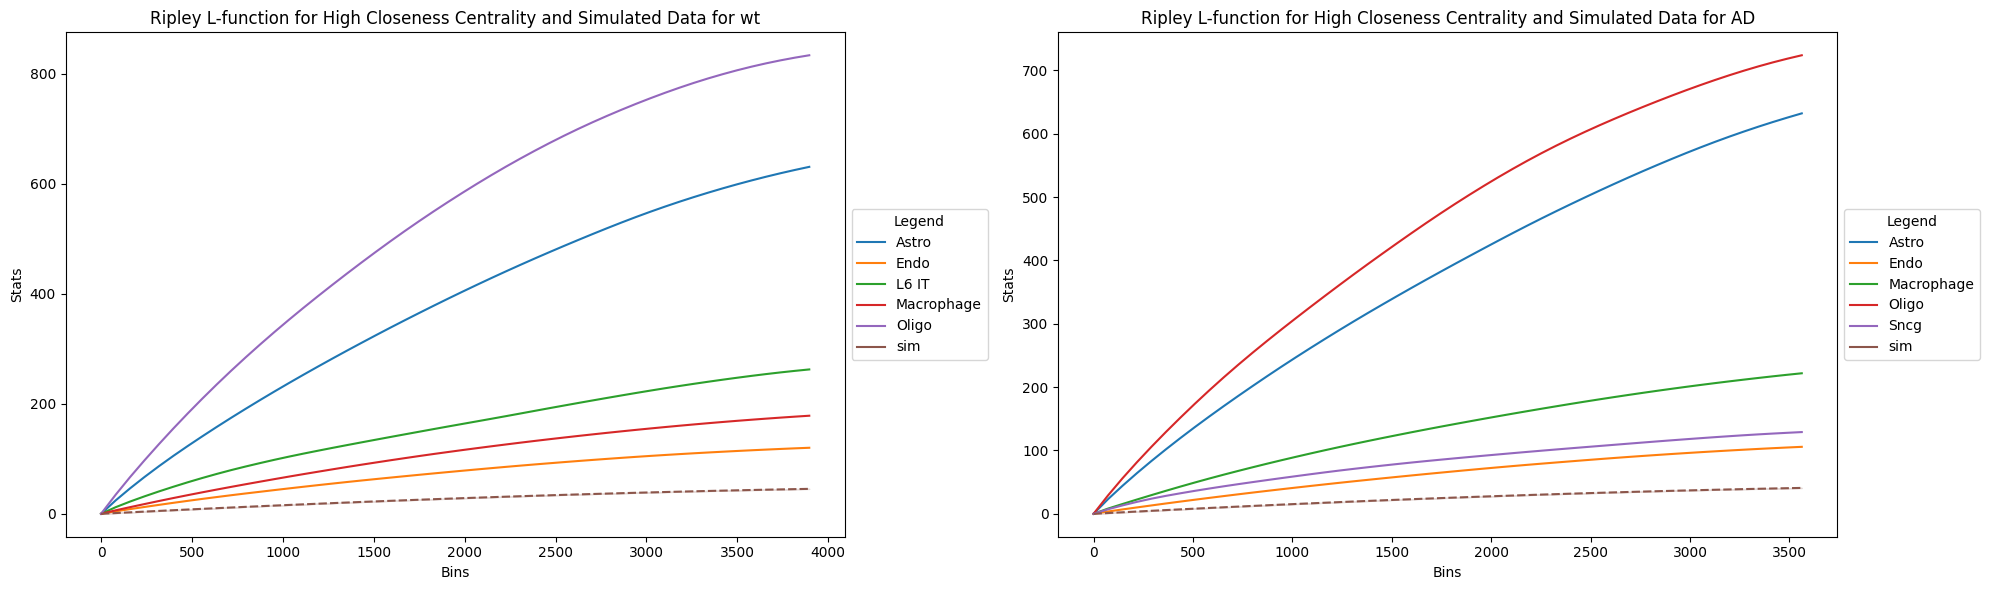

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming sim DataFrame has similar structure with 'bins', 'stats', and 'cell_label' or equivalent columns
# If necessary, adjust the columns to match those in df_cell_ripley_high_cen

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

for i, adata in enumerate(adatas):
    # Add a distinguishing column
    df_cell_ripley_high_cen[i]['source'] = 'High Closeness Centrality'
    sim[i]['source'] = 'Simulated Data'

    # Ensure columns match, renaming if necessary
    # Assuming sim has columns 'bins' and 'stats' similar to df_cell_ripley_high_cen
    # If 'cell_label' is not present, you may need to adjust accordingly
    if 'cell_label' not in sim[i].columns:
        sim[i]['cell_label'] = 'Simulated'  # or any other distinguishing label

    # Concatenate DataFrames
    combined_df = pd.concat([df_cell_ripley_high_cen[i], sim[i]])

    # Plotting
    ax = sns.lineplot(data=combined_df, x='bins', y='stats', hue='cell_label', style='source', legend='brief', ax=axs[i])

    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    # Filter out the legends that are in the combined DataFrame
    filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l in combined_df['cell_label'].unique()]
    handles, labels = zip(*filtered_handles_labels)
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

    # Set plot title and labels
    ax.set_title(f'Ripley L-function for High Closeness Centrality and Simulated Data for {names[i]}')
    ax.set_xlabel('Bins')
    ax.set_ylabel('Stats')

plt.tight_layout()
# Show plot
plt.show()
